In [ ]:
# import some useful preprocessing packages
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
# define our main path
path = "C:/Users/xxxxx/Downloads/xxxxxx/trip_data_train"

In [ ]:
# Loading one trip data file
filepath = path + '/0001.csv'
file = pd.read_csv(filepath)

In [ ]:
file.head()

,time_seconds,speed_meters_per_second,heading_degrees
0,0.000,9.170000,NaN
1,0.994,9.311178,NaN
2,1.711,11.184463,NaN
3,2.711,11.820962,89.572280
4,3.711,12.141592,89.334795


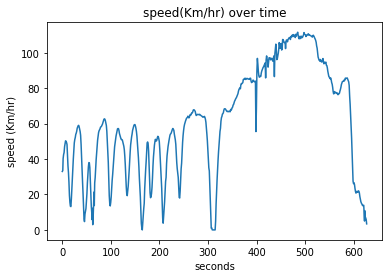

In [ ]:
# Plotting speed over the trip time
plt.plot(file.time_seconds,file.speed_meters_per_second*3.6)
plt.title('speed(Km/hr) over time')
plt.xlabel('seconds')
plt.ylabel('speed (Km/hr)')
plt.show()

### Observation:
Speed doesn't come down to an absolute zero and hence, any speed that is less than 0.01 m/s is considered a stop

In [ ]:
# Calculating the number of stops
# conditions:
# 1. Speed less than 0.01 m/s considered a stop
file['stops'] = (file.speed_meters_per_second<0.01)*1

# 2. Continum of speed measurements less than 0.01 m/s are considered a halt
n=len(file.stops)
file.loc[0,'stops']=0 # starting point and ending point could be zero and aren't being considered stops
file.loc[n,'stops']=0
for i in range(n-1):
    if(i<n-4):
        if(file.stops[n-i-2]+file.stops[n-i-3]+file.stops[n-i-4]>0):
            file.loc[n-i-1,'stops']=0
    elif(i==n-3):
        if(file.stops[n-i-2]+file.stops[n-i-3]>0):
            file.loc[n-i-1,'stops']=0
    else:
        if(file.stops[n-i-2]>0):
            file.loc[n-i-1,'stops']=0

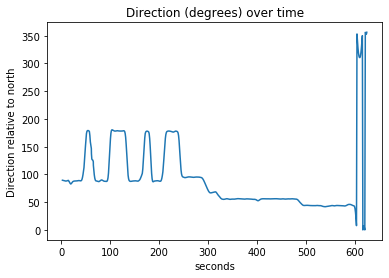

In [ ]:
# Plotting direction change over the ride period
plt.plot(file.time_seconds,file.heading_degrees)
plt.title('Direction (degrees) over time')
plt.xlabel('seconds')
plt.ylabel('Direction relative to north')
plt.show()

### Observation:
Direction is ranging from 0 to 360 - need to handle jumps around 360 to zero and viceversa

###### Assumption:
During a turn, the direction change is expected to be consistently clockwise or anti-clockwise 
Taking direction change over a period of 2 seconds for smoothening reason

In [ ]:
# Getting the direction after 2 secs - will be used to get the direction change
file['degrees_after_2_sec'] = file.heading_degrees.shift(-2)

In [ ]:
# Getting direction after 2 seconds for every data point
file['degrees_diff_2_sec'] = file.degrees_after_2_sec - file.heading_degrees

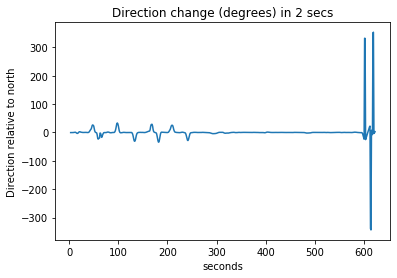

In [ ]:
# Plotting the direction change to check the smoothness of rate of direction change (increase or decrease)
plt.plot(file.time_seconds,file.degrees_diff_2_sec)
plt.title('Direction change (degrees) in 2 secs')
plt.xlabel('seconds')
plt.ylabel('Direction relative to north')
plt.show()

In [ ]:
# Checking the range of change in direction
for i in [0,1,10,20,30,40,50,60,70,80,90,99,100]:
    print(np.nanpercentile(file.degrees_diff_2_sec,i))

-343.63176919999995
-29.511755319999992
-3.2923345333333485
-0.8190627999999887
-0.3260950400000041
-0.14866759999999318
-0.06195599999978185
0.04263335999998929
0.1846001200000017
0.39305063999997863
1.9465389066666925
30.36249361999993
353.3335851999999


#### We observe that <2% of the times direction change is over 30 degrees

In [ ]:
# Any direction change around zero/360 degrees will result in erroneous calculations of degrees_diff_2_sec
file.loc[file.degrees_diff_2_sec>180,'degrees_diff_2_sec'] = file.loc[file.degrees_diff_2_sec>180,'degrees_diff_2_sec'] - 360
file.loc[file.degrees_diff_2_sec<-180,'degrees_diff_2_sec'] = file.loc[file.degrees_diff_2_sec<-180,'degrees_diff_2_sec'] + 360

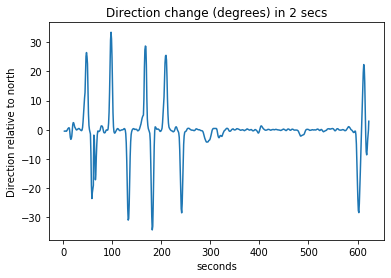

In [ ]:
# Checking the range of change in direction after handling the special case of movements around zero degrees
plt.plot(file.time_seconds,file.degrees_diff_2_sec)
plt.title('Direction change (degrees) in 2 secs')
plt.xlabel('seconds')
plt.ylabel('Direction relative to north')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


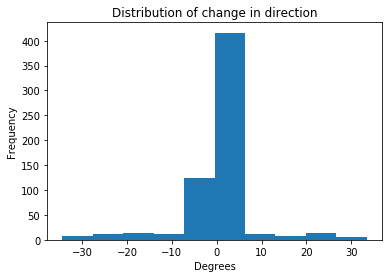

In [ ]:
# plot to check the distribution of 'degrees_diff_2_sec'
plt.hist(file.degrees_diff_2_sec)
plt.title('Distribution of change in direction')
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Creating a flag to check if the direction change over 2 second period was clockwise
file['clockwise']=0
file.loc[file.degrees_diff_2_sec>0,'clockwise'] = 1

In [ ]:
# Looping through to identify times where the vehicle changed the direction continuously clockwise/anti-clockwise 
# and determine if those instances can be classified as turns
file['turn_deg']=0
file['turn_end']=0
for i in range(len(file.clockwise)):
    if(np.isnan(file.degrees_diff_2_sec[i])):
        file.loc[i,'turn_deg']=0
        file.loc[i,'turn_end']=0
    elif(i==0):
        turn_start_deg = file.loc[i,'heading_degrees']
        file.loc[i,'turn_end']=1
        file.loc[i,'turn_deg']=0
    elif(np.isnan(file.degrees_diff_2_sec[i-1]) or i==0):
        turn_start_deg = file.loc[i,'heading_degrees']
        file.loc[i,'turn_end']=1
        file.loc[i,'turn_deg']=0
    elif(file.clockwise[i-1]==file.clockwise[i]):
        file.loc[i,'turn_end']=1
        file.loc[i-1,'turn_end']=0
        file.loc[i,'turn_deg']=file.loc[i,'heading_degrees'] - turn_start_deg
        file.loc[i-1,'turn_deg']=0
    else:
        file.loc[i-1,'turn_deg'] = file.loc[i-1,'heading_degrees'] - turn_start_deg
        turn_start_deg = file.loc[i,'heading_degrees']
        file.loc[i,'turn_end']=1


file.loc[file.clockwise==0,'turn_deg'] = file.loc[file.clockwise==0,'turn_deg']*-1
file.loc[file.turn_deg<-60,'turn_deg'] = file.loc[file.turn_deg<-60,'turn_deg'] +360 # Here 60 is picked to be safe as the turn_deg is still expected to have negative values at places as we are relying on clockwise column which is created based on direction change in 2 seconds
file.loc[abs(file.turn_deg)<60,'turn_end']=0

In [ ]:
sum(file.turn_end)

9

In [ ]:
#file.to_csv('C:/Users/xxxxx/Downloads/xxxxxx/trip_data_train/0001_mod.csv',index=False)

In [ ]:
filenames=[]
stops=[]
turns=[]
for filename in sorted(os.listdir(path)):
    #print(filename)
    filepath = path + '/' + filename
    file = pd.read_csv(filepath)
    # Number of stops
    file['stops'] = (file.speed_meters_per_second<0.01)*1
    n=len(file.stops)
    file.loc[0,'stops']=0
    file.loc[n,'stops']=0
    for i in range(n-1):
        if(i<n-4):
            if(file.stops[n-i-2]+file.stops[n-i-3]+file.stops[n-i-4]>0):
                file.loc[n-i-1,'stops']=0
        elif(i==n-3):
            if(file.stops[n-i-2]+file.stops[n-i-3]>0):
                file.loc[n-i-1,'stops']=0
        else:
            if(file.stops[n-i-2]>0):
                file.loc[n-i-1,'stops']=0
    
    # getting turns
    file['degrees_after_2_sec'] = file.heading_degrees.shift(-2)
    file['degrees_diff_2_sec'] = file.degrees_after_2_sec - file.heading_degrees
    file.loc[file.degrees_diff_2_sec>180,'degrees_diff_2_sec'] = file.loc[file.degrees_diff_2_sec>180,'degrees_diff_2_sec'] - 360
    file.loc[file.degrees_diff_2_sec<-180,'degrees_diff_2_sec'] = file.loc[file.degrees_diff_2_sec<-180,'degrees_diff_2_sec'] + 360
    file['clockwise']=0
    file.loc[file.degrees_diff_2_sec>0,'clockwise'] = 1
    
    file['turn_deg']=0
    file['turn_end']=0
    for i in range(len(file.clockwise)):
        if(np.isnan(file.degrees_diff_2_sec[i])):
            file.loc[i,'turn_deg']=0
            file.loc[i,'turn_end']=0
        elif(i==0):
            turn_start_deg = file.loc[i,'heading_degrees']
            file.loc[i,'turn_end']=1
            file.loc[i,'turn_deg']=0
        elif(np.isnan(file.degrees_diff_2_sec[i-1])):
            turn_start_deg = file.loc[i,'heading_degrees']
            file.loc[i,'turn_end']=1
            file.loc[i,'turn_deg']=0
        elif(file.clockwise[i-1]==file.clockwise[i]):
            file.loc[i,'turn_end']=1
            file.loc[i-1,'turn_end']=0
            file.loc[i,'turn_deg']=file.loc[i,'heading_degrees'] - turn_start_deg
            file.loc[i-1,'turn_deg']=0
        else:
            file.loc[i-1,'turn_deg'] = file.loc[i-1,'heading_degrees'] - turn_start_deg
            turn_start_deg = file.loc[i,'heading_degrees']
            file.loc[i,'turn_end']=1
    file.loc[file.clockwise==0,'turn_deg'] = file.loc[file.clockwise==0,'turn_deg']*-1
    file.loc[file.turn_deg<-60,'turn_deg'] = file.loc[file.turn_deg<-60,'turn_deg'] +360
    file.loc[abs(file.turn_deg)<60,'turn_end']=0
   
    filenames.append(filename)
    stops.append(sum(file.stops))
    turns.append(sum(file.turn_end))

data_newcols = {'filename':filenames,'stops':stops,'turns':turns}
newcols = pd.DataFrame(data=data_newcols)

In [ ]:
#newcols.to_csv("C:/Users/xxxxx/Downloads/xxxxxx/turns_stops.csv")

In [ ]:
# Loading model_train_data
model_train_data = pd.read_csv("C:/Users/xxxxx/Downloads/xxxxxx/model_data_train.csv")

In [ ]:
model_train_data.head()

,filename,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,y
0,0000.csv,False,False,True,5.209096,9789.261511,30753.872048,0.001010,5,13,1,9.373984e+03,0.317920,9.379193e+03,4.974085,0
1,0001.csv,False,False,False,4.450941,10552.521899,33151.725274,0.001000,3,11,1,4.251619e+04,2.229321,4.252064e+04,3.151531,0
2,0002.csv,False,False,True,5.396552,10233.433119,32149.278307,0.001015,6,13,1,1.305321e+07,34.259512,1.305322e+07,6.236594,0
3,0003.csv,False,False,True,4.970163,10829.056746,34020.485118,0.000993,4,8,1,1.131908e+03,25.768714,1.136878e+03,3.968008,1
4,0004.csv,False,False,False,5.266868,10678.703687,33548.137053,0.001009,6,11,1,3.163256e+03,145.154357,3.168523e+03,5.999782,0


In [ ]:
# Appending 'stops' & 'turns' variables to model_train_data 
train_data = model_train_data.join(newcols.set_index('filename'), on='filename')
train_data.head()

,filename,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,y,stops,turns
0,0000.csv,False,False,True,5.209096,9789.261511,30753.872048,0.001010,5,13,1,9.373984e+03,0.317920,9.379193e+03,4.974085,0,0.0,3
1,0001.csv,False,False,False,4.450941,10552.521899,33151.725274,0.001000,3,11,1,4.251619e+04,2.229321,4.252064e+04,3.151531,0,2.0,9
2,0002.csv,False,False,True,5.396552,10233.433119,32149.278307,0.001015,6,13,1,1.305321e+07,34.259512,1.305322e+07,6.236594,0,0.0,4
3,0003.csv,False,False,True,4.970163,10829.056746,34020.485118,0.000993,4,8,1,1.131908e+03,25.768714,1.136878e+03,3.968008,1,3.0,7
4,0004.csv,False,False,False,5.266868,10678.703687,33548.137053,0.001009,6,11,1,3.163256e+03,145.154357,3.168523e+03,5.999782,0,5.0,3


In [ ]:
# Checking dependent variable event rate
np.mean(train_data.y)
# Dataset is slightly imbalanced

0.31

In [ ]:
train_data.isnull().sum()
# None of the columns have missing values

filename     0
feature1     0
feature2     0
feature3     0
feature4     0
feature5     0
feature6     0
feature7     0
feature8     0
feature9     0
feature10    0
feature11    0
feature12    0
feature13    0
feature14    0
y            0
stops        0
turns        0
dtype: int64

In [ ]:
# Checking variable data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
filename     1000 non-null object
feature1     1000 non-null bool
feature2     1000 non-null bool
feature3     1000 non-null bool
feature4     1000 non-null float64
feature5     1000 non-null float64
feature6     1000 non-null float64
feature7     1000 non-null float64
feature8     1000 non-null int64
feature9     1000 non-null int64
feature10    1000 non-null int64
feature11    1000 non-null float64
feature12    1000 non-null float64
feature13    1000 non-null float64
feature14    1000 non-null float64
y            1000 non-null int64
stops        1000 non-null float64
turns        1000 non-null int64
dtypes: bool(3), float64(9), int64(5), object(1)
memory usage: 120.2+ KB


In [ ]:
# Dropping 'filename' column and converting boolean columns to numeric 
train_data.drop(['filename'],axis=1,inplace=True)
train_data['feature1']=train_data['feature1']*1
train_data['feature2']=train_data['feature2']*1
train_data['feature3']=train_data['feature3']*1

In [ ]:
# Checking event rate of the converted boolean columns
for i in [0,1,2]:
    print(np.mean(train_data.iloc[:,i]))

0.102
0.0
0.507


In [ ]:
# Removing variables that have no variance/single-value repeating throughout
lst = []
for i in range(train_data.shape[1]):
    v=np.var(train_data.iloc[:,i])
    if(v==0):
        lst.append(train_data.columns[i])

train_data.drop(lst,axis=1,inplace=True)
print("Columns dropped: \n", lst)

Columns dropped: 
 ['feature2', 'feature10']


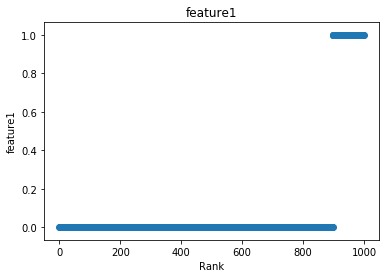

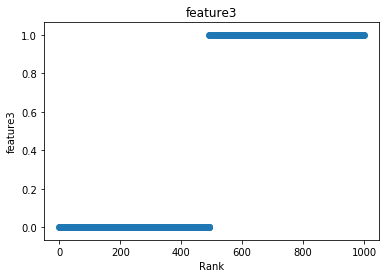

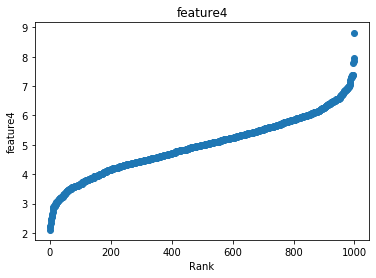

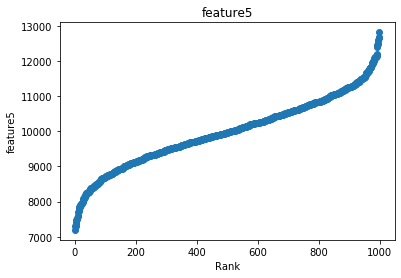

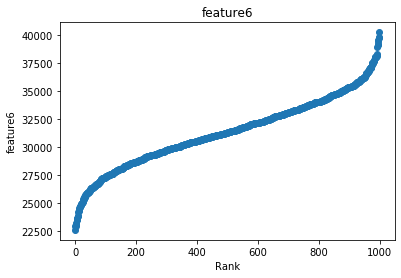

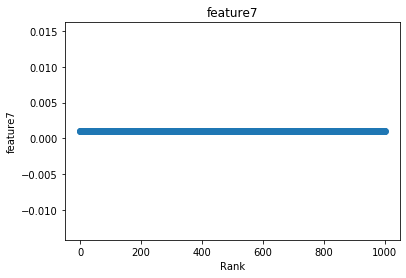

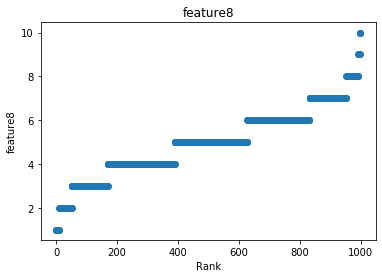

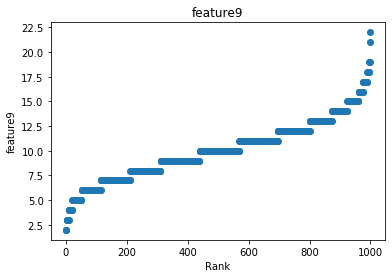

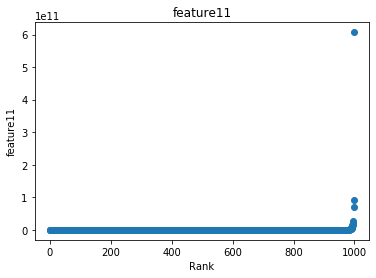

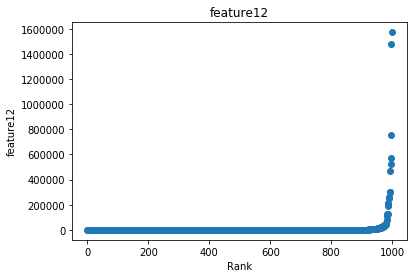

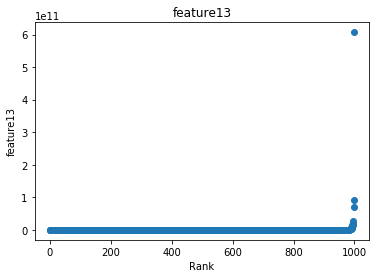

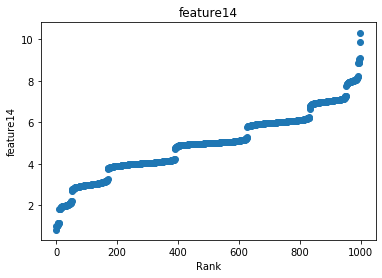

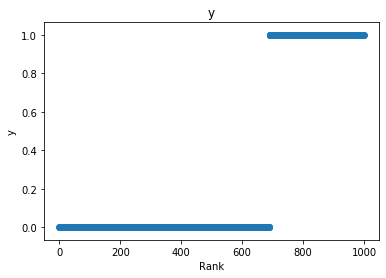

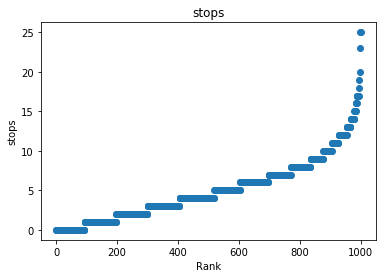

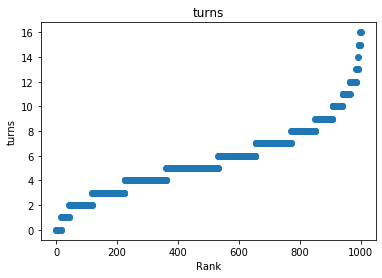

In [ ]:
# checking for outliers - using graph method as there are only 15 variables
for i in range(len(train_data.columns)):
    plt.scatter(list(range(train_data.shape[0])), train_data.sort_values(train_data.columns[i]).loc[:,train_data.columns[i]])
    plt.title(train_data.columns[i])
    plt.xlabel('Rank')
    plt.ylabel(train_data.columns[i])
    plt.show()

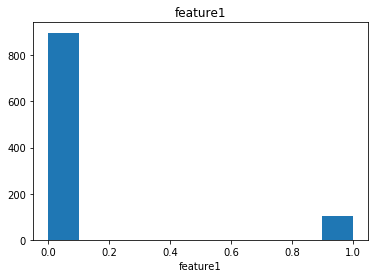

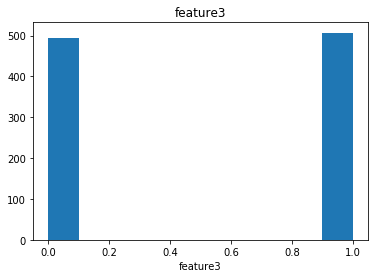

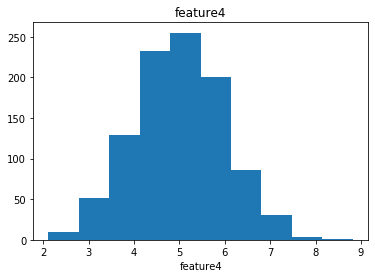

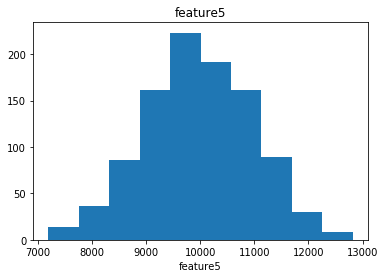

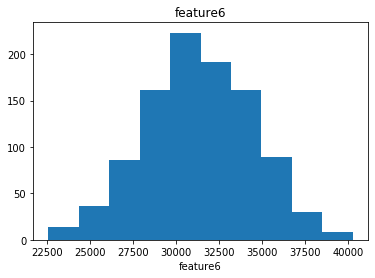

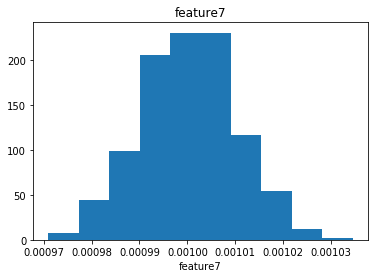

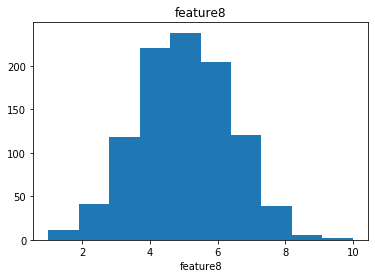

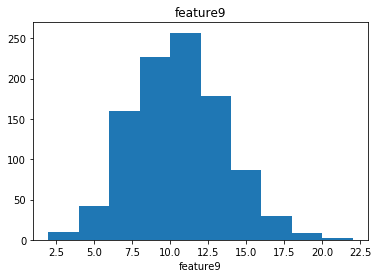

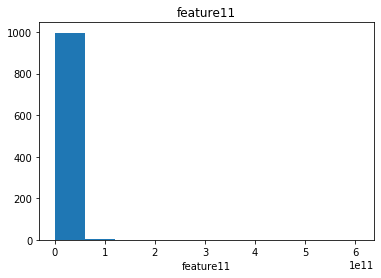

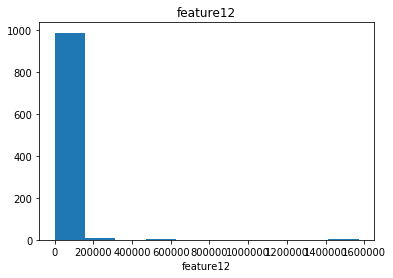

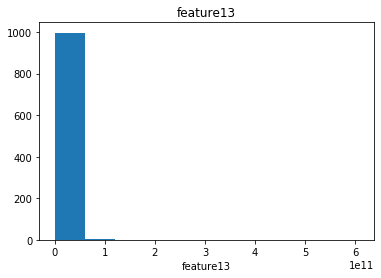

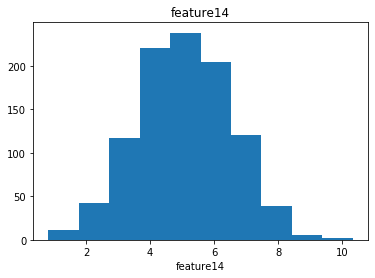

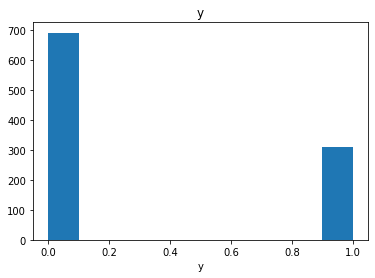

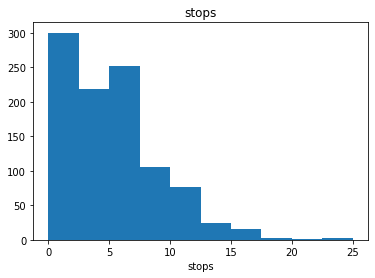

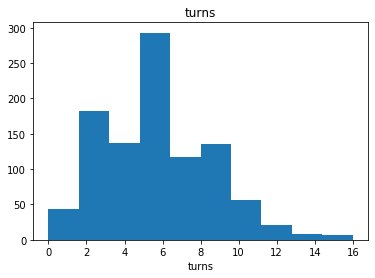

In [ ]:
# Checking variable distributions
for i in range(len(train_data.columns)):
    plt.hist(train_data.loc[:,train_data.columns[i]])
    plt.title(train_data.columns[i])
    plt.xlabel(train_data.columns[i])
    plt.show()

In [ ]:
# Above graphs show that feature11, feature12 & feature13 have very large values
# checking the stats of these variables
train_data.feature11.describe(), train_data.feature12.describe(), train_data.feature13.describe()

(count    1.000000e+03
 mean     8.861258e+08
 std      1.957633e+10
 min      8.550778e-03
 25%      7.959224e+02
 50%      2.294823e+04
 75%      6.395295e+05
 max      6.069658e+11
 Name: feature11, dtype: float64, count    1.000000e+03
 mean     8.845462e+03
 std      8.087624e+04
 min      4.504803e-08
 25%      1.320425e-01
 50%      2.744109e+00
 75%      7.829274e+01
 max      1.572134e+06
 Name: feature12, dtype: float64, count    1.000000e+03
 mean     8.861258e+08
 std      1.957633e+10
 min      4.320016e+00
 25%      8.009469e+02
 50%      2.295354e+04
 75%      6.395340e+05
 max      6.069658e+11
 Name: feature13, dtype: float64)

In [ ]:
# feature11, feature12 & feature13 seem to be having very wide range. 
# Taking a logarithm would transform the variables to have smaller range
trans_cols = ['feature11', 'feature12', 'feature13']
for i in trans_cols:
    train_data.loc[:,i]=np.log(train_data.loc[:,i])

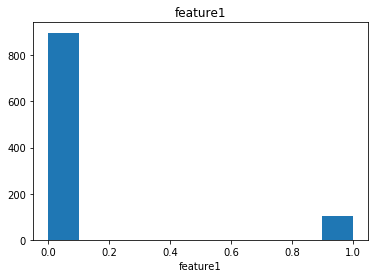

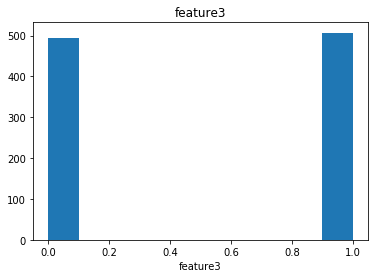

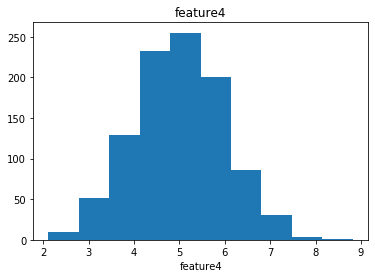

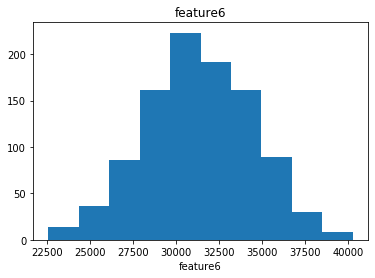

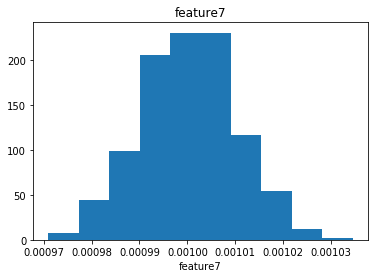

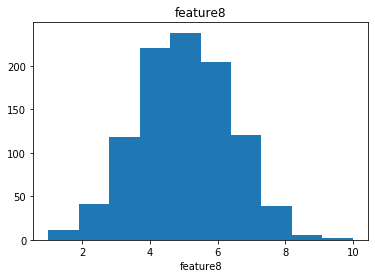

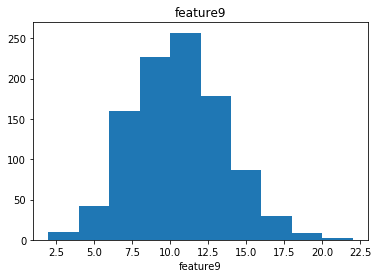

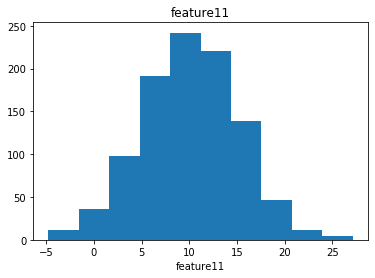

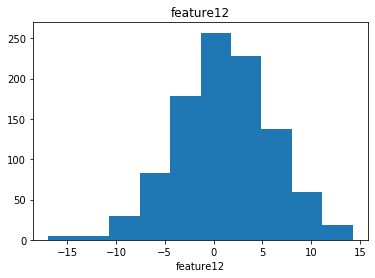

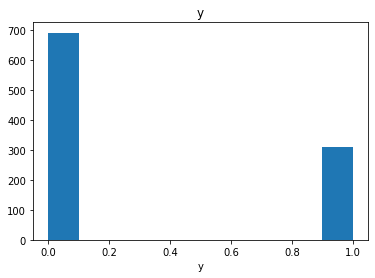

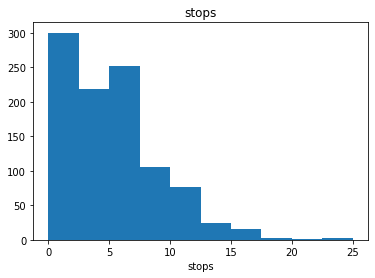

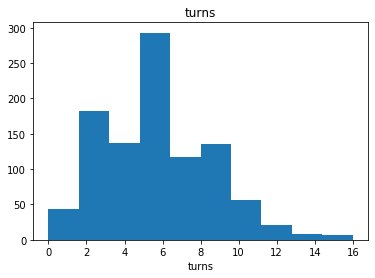

In [ ]:
# Checking variable distributions after transformation
for i in range(len(train_data.columns)):
    plt.hist(train_data.loc[:,train_data.columns[i]])
    plt.title(train_data.columns[i])
    plt.xlabel(train_data.columns[i])
    plt.show()

In [ ]:
# calculating correlation between variables
corrmat = train_data.corr()
corrmat

,feature1,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature11,feature12,feature13,feature14,y,stops,turns
feature1,1.000000,-0.024546,0.076748,-0.010892,-0.010892,0.013701,-0.002862,-0.005926,-0.079969,0.001417,-0.070139,0.000703,-0.197324,-0.031057,-0.006948
feature3,-0.024546,1.000000,0.049156,0.015374,0.015374,-0.003785,0.014374,0.039904,-0.018395,0.008155,-0.019309,0.014839,-0.100206,0.056938,-0.047488
feature4,0.076748,0.049156,1.000000,-0.003980,-0.003980,0.007913,-0.024669,0.031543,-0.018850,-0.022162,-0.014525,-0.024833,-0.191783,-0.010455,-0.007475
feature5,-0.010892,0.015374,-0.003980,1.000000,1.000000,-0.004376,-0.006412,-0.035361,-0.063082,0.023191,-0.066261,-0.005600,-0.057884,-0.006386,0.027999
feature6,-0.010892,0.015374,-0.003980,1.000000,1.000000,-0.004376,-0.006412,-0.035361,-0.063082,0.023191,-0.066261,-0.005600,-0.057884,-0.006386,0.027999
feature7,0.013701,-0.003785,0.007913,-0.004376,-0.004376,1.000000,-0.000557,0.032509,-0.004024,-0.010469,-0.002830,0.001717,-0.384853,-0.003326,-0.014520
feature8,-0.002862,0.014374,-0.024669,-0.006412,-0.006412,-0.000557,1.000000,0.017778,-0.010730,-0.031544,-0.002733,0.998071,0.050106,-0.054613,-0.025506
feature9,-0.005926,0.039904,0.031543,-0.035361,-0.035361,0.032509,0.017778,1.000000,-0.042928,-0.084509,-0.045358,0.017346,-0.471630,0.034327,-0.074155
feature11,-0.079969,-0.018395,-0.018850,-0.063082,-0.063082,-0.004024,-0.010730,-0.042928,1.000000,-0.008230,0.993280,-0.009905,0.024379,0.000584,-0.047582
feature12,0.001417,0.008155,-0.022162,0.023191,0.023191,-0.010469,-0.031544,-0.084509,-0.008230,1.000000,-0.003034,-0.028011,0.039609,-0.005022,0.017231


In [ ]:
#f, ax = plt.subplots(figsize =(9, 8))
#sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

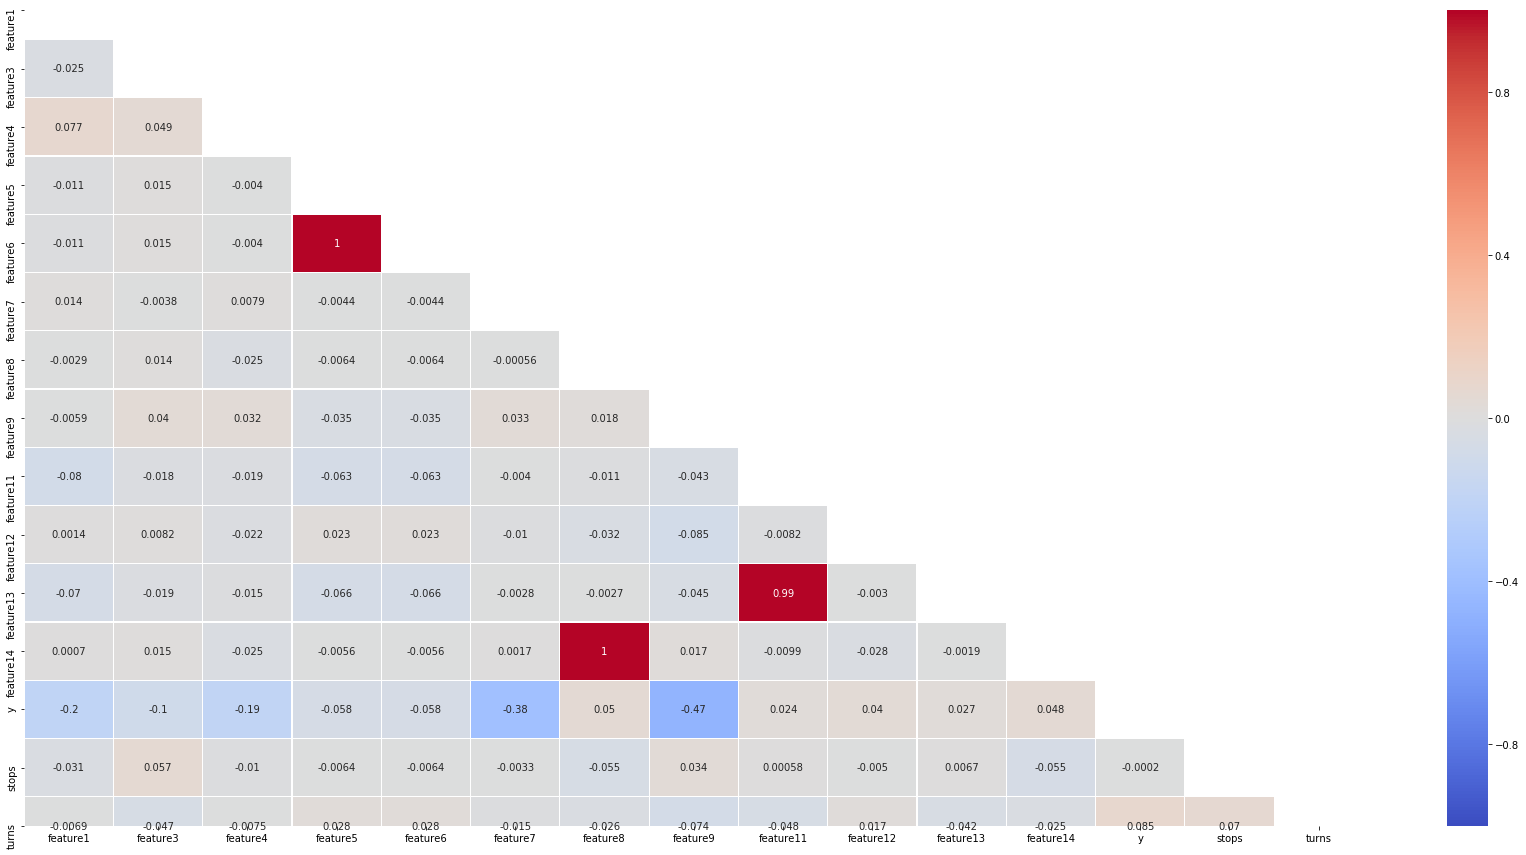

In [ ]:
# Plotting the correlations between variables
plt.figure(figsize=(30, 15))
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corrmat, xticklabels=corrmat.columns, yticklabels=corrmat.columns, 
                 linewidths=.2, cmap='coolwarm',vmin=-1, annot=True, mask=mask)

In [ ]:
# Dropping variable that are strongly correlated to other variables
train_data=train_data.drop('feature5', axis=1)
train_data=train_data.drop('feature13', axis=1)
train_data=train_data.drop('feature14', axis=1)

In [ ]:
#Splitting the data into train & test for modelling
from sklearn.model_selection import train_test_split
X = train_data.drop(['y'], axis=1)
y = train_data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state= 25)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(750, 11) (250, 11)
(750,) (250,)


In [ ]:
#Scaling all the variables using MinMaxscaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test =scaler.transform(X_test)

In [ ]:
#train_data.to_csv("C:/Users/xxxxx/Downloads/xxxxxx/cleaned_data.csv")

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection

In [ ]:
# Writing a function to print best score and best parameters from a grid search
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [ ]:
# Defining grid search parameters and running gridsearch with logistic regression
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.01, 1, 5, 10, 50, 100, 1000)
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (0.01, 1, 5, 10, 50, 100, 1000),
                         'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# Printing best score and parameters using the custom function defined above
print_grid_search_metrics(Grid_LR)

Best score: 0.8653333333333334
Best parameters set:
C:10
penalty:l1


In [ ]:
# Getting performance on test dataset
predictions_lr_grid=Grid_LR.predict(X_test)
print(f"Accuracy: {metrics.accuracy_score(y_test,predictions_lr_grid)}")
print(f"AUC: {metrics.roc_auc_score(y_test,predictions_lr_grid)}")

Accuracy: 0.844
AUC: 0.799045915324985


              precision    recall  f1-score   support

           0       0.86      0.92      0.89       172
           1       0.79      0.68      0.73        78

    accuracy                           0.84       250
   macro avg       0.83      0.80      0.81       250
weighted avg       0.84      0.84      0.84       250



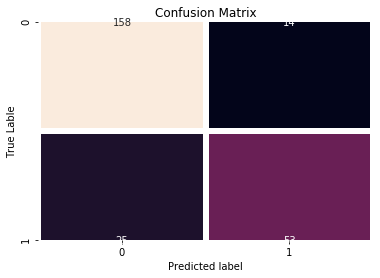

In [ ]:
# Confusion matrix - Logistic regression
conf_matrix=confusion_matrix(y_test ,predictions_lr_grid)
sns.heatmap(conf_matrix, annot=True, fmt="d",linewidth=5,cbar=False)
plt.ylabel('True Lable')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix")
print(classification_report(y_test, predictions_lr_grid))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

# Defining grid search parameters and running gridsearch with RandomForest
parameters = {
    'n_estimators' : [50, 75, 100, 200, 500, 750, 1000],
    'max_depth' : list(range(2,16,2)),
    'min_samples_split' : list(range(2,10,1))
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.8653333333333334
Best parameters set:
max_depth:8
min_samples_split:4
n_estimators:75


In [ ]:
# best random forest
best_RF_model = Grid_RF.best_estimator_
best_RF_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=75,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# randomForest performance on test dataset
predictions_rf_grid=Grid_RF.predict(X_test)
print(f"Accuracy: {metrics.accuracy_score(y_test,predictions_rf_grid)}")
print(f"AUC: {metrics.roc_auc_score(y_test,predictions_rf_grid)}")

Accuracy: 0.808
AUC: 0.7343470483005365


              precision    recall  f1-score   support

           0       0.82      0.93      0.87       172
           1       0.78      0.54      0.64        78

    accuracy                           0.81       250
   macro avg       0.80      0.73      0.75       250
weighted avg       0.80      0.81      0.80       250



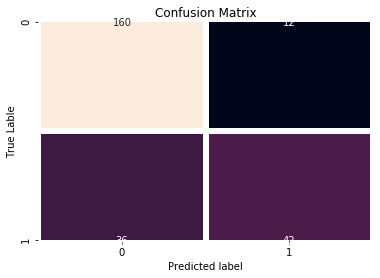

In [ ]:
# Confusion matrix - randomForest
conf_matrix=confusion_matrix( y_test ,predictions_rf_grid)
sns.heatmap(conf_matrix, annot=True, fmt="d",linewidth=5,cbar=False)
plt.ylabel('True Lable')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix")
print(classification_report(y_test, predictions_rf_grid))

In [ ]:
# Gradient boosting model
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    'n_estimators' : [30],
#    'n_estimators' : range(10,101,10),
    'max_depth': [3],
#    'max_depth':range(2,4,1), 
    'min_samples_split':[70],
#    'min_samples_split':range(60,90,5),
    'min_samples_leaf':[5],
#    'min_samples_leaf':range(5,31,5),
    'max_features':[3],
#    'max_features':range(2,7,1),
    'subsample':[0.65]
#    'subsample':[0.5,0.55,0.6,0.65, 0.7]
}
Grid_gbm = GridSearchCV(GradientBoostingClassifier(),parameters, cv=5)
Grid_gbm.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [ ]:
print_grid_search_metrics(Grid_gbm)

Best score: 0.8386666666666667
Best parameters set:
max_depth:3
max_features:3
min_samples_leaf:5
min_samples_split:70
n_estimators:30
subsample:0.65


In [ ]:
best_gbm_model = Grid_gbm.best_estimator_
best_gbm_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=3, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=5, min_samples_split=70,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.65, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# GBM performance on test dataset
predictions_gbm_grid=Grid_gbm.predict(X_test)
print(f"Accuracy: {metrics.accuracy_score(y_test,predictions_gbm_grid)}")
print(f"AUC: {metrics.roc_auc_score(y_test,predictions_gbm_grid)}")

Accuracy: 0.788
AUC: 0.7022957662492546


              precision    recall  f1-score   support

           0       0.80      0.93      0.86       172
           1       0.76      0.47      0.58        78

    accuracy                           0.79       250
   macro avg       0.78      0.70      0.72       250
weighted avg       0.78      0.79      0.77       250



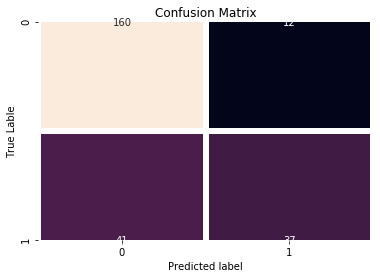

In [ ]:
# Confusion matrix - GBM
conf_matrix=confusion_matrix( y_test ,predictions_gbm_grid)
sns.heatmap(conf_matrix, annot=True, fmt="d",linewidth=5,cbar=False)
plt.ylabel('True Lable')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix")
print(classification_report(y_test, predictions_gbm_grid))

### Final Model:
#### Logistic regression is chosen over randomForest and Gradient Boosting models as it has higher accuracy and AUC on Test dataset.

## Writing the code to predict on new data

In [ ]:
path_test = "C:/Users/xxxxx/Downloads/xxxxxx/trip_data_test"
filenames=[]
stops=[]
turns=[]
for filename in sorted(os.listdir(path_test)):
    #print(filename)
    filepath = path_test + '/' + filename
    file = pd.read_csv(filepath)
    # Number of stops
    file['stops'] = (file.speed_meters_per_second<0.01)*1
    n=len(file.stops)
    file.loc[0,'stops']=0
    file.loc[n,'stops']=0
    for i in range(n-1):
        if(i<n-4):
            if(file.stops[n-i-2]+file.stops[n-i-3]+file.stops[n-i-4]>0):
                file.loc[n-i-1,'stops']=0
        elif(i==n-3):
            if(file.stops[n-i-2]+file.stops[n-i-3]>0):
                file.loc[n-i-1,'stops']=0
        else:
            if(file.stops[n-i-2]>0):
                file.loc[n-i-1,'stops']=0
    
    # getting turns
    file['degrees_after_2_sec'] = file.heading_degrees.shift(-2)
    file['degrees_diff_2_sec'] = file.degrees_after_2_sec - file.heading_degrees
    file.loc[file.degrees_diff_2_sec>180,'degrees_diff_2_sec'] = file.loc[file.degrees_diff_2_sec>180,'degrees_diff_2_sec'] - 360
    file.loc[file.degrees_diff_2_sec<-180,'degrees_diff_2_sec'] = file.loc[file.degrees_diff_2_sec<-180,'degrees_diff_2_sec'] + 360
    file['clockwise']=0
    file.loc[file.degrees_diff_2_sec>0,'clockwise'] = 1
    
    file['turn_deg']=0
    file['turn_end']=0
    for i in range(len(file.clockwise)):
        if(np.isnan(file.degrees_diff_2_sec[i])):
            file.loc[i,'turn_deg']=0
            file.loc[i,'turn_end']=0
        elif(i==0):
            turn_start_deg = file.loc[i,'heading_degrees']
            file.loc[i,'turn_end']=1
            file.loc[i,'turn_deg']=0
        elif(np.isnan(file.degrees_diff_2_sec[i-1])):
            turn_start_deg = file.loc[i,'heading_degrees']
            file.loc[i,'turn_end']=1
            file.loc[i,'turn_deg']=0
        elif(file.clockwise[i-1]==file.clockwise[i]):
            file.loc[i,'turn_end']=1
            file.loc[i-1,'turn_end']=0
            file.loc[i,'turn_deg']=file.loc[i,'heading_degrees'] - turn_start_deg
            file.loc[i-1,'turn_deg']=0
        else:
            file.loc[i-1,'turn_deg'] = file.loc[i-1,'heading_degrees'] - turn_start_deg
            turn_start_deg = file.loc[i,'heading_degrees']
            file.loc[i,'turn_end']=1
    file.loc[file.clockwise==0,'turn_deg'] = file.loc[file.clockwise==0,'turn_deg']*-1
    file.loc[file.turn_deg<-60,'turn_deg'] = file.loc[file.turn_deg<-60,'turn_deg'] +360
    file.loc[abs(file.turn_deg)<60,'turn_end']=0
   
    filenames.append(filename)
    stops.append(sum(file.stops))
    turns.append(sum(file.turn_end))

data_newcols_test = {'filename':filenames,'stops':stops,'turns':turns}
newcols_test = pd.DataFrame(data=data_newcols_test)

model_test_data = pd.read_csv("C:/Users/xxxxx/Downloads/xxxxxx/model_data_test.csv")
test_data = model_test_data.join(newcols_test.set_index('filename'), on='filename')
#test_data.drop(['filename'],axis=1,inplace=True)
test_data['feature1']=test_data['feature1']*1
test_data['feature2']=test_data['feature2']*1
test_data['feature3']=test_data['feature3']*1
test_data.drop(lst,axis=1,inplace=True)
trans_cols = ['feature11', 'feature12', 'feature13']
for i in trans_cols:
    test_data.loc[:,i]=np.log(test_data.loc[:,i])
test_data=test_data.drop('feature5', axis=1)
test_data=test_data.drop('feature13', axis=1)
test_data=test_data.drop('feature14', axis=1)
test_X=test_data.drop(['filename'],axis=1)
test_X =scaler.transform(test_X)
test_data['prediction']=Grid_LR.predict(test_X)

test_data.loc[:,['filename','prediction']].to_csv("C:/Users/xxxxx/Downloads/xxxxxx/test_data_predictions.csv",index=False)

# Summary
##### Final outcome: - Out-of-sample dataset is expected to have 84% accuracy with 79% precision and 68% recall.
#### Exercise:
Extracted number of stops and turns in each ride using the separate csv files provided and appended these variables to given 14 other variables to predict if a ride was 'interesting' or not as defined by the variable 'y' in training data.
##### Stops and turns extraction logic:
###### Stops:
Every time the speed went below 0.01 m/s, it would be marked as a stop. One exception here is that starting and ending data points in a ride are never considered as stops. An instance is not marked as a stop if there was a stop in last 3 secs.
###### Turns:
To identify turns from direction information, it is assumed that a turn will have consistent change of direction either clockwise or anti-clockwise. Continuous streak of observations with consistent change of direction are considered a turn & magnitude of change in direction is computed. If the change in direction in a turn is over 60 degrees then it is would be retained as a turn else it would be considered a non-turn.
Note: while checking for consistency in change of direction in the exercise of classifying a set of observations as part of a single turn, change is taken over a period of 2 seconds rather than 1 sec (or two consecutive observations) for smoothening reasons and allow for random small fluctuations change direction in the middle of a turn.
##### Data preparation and Modeling:
1) Data with 14 features and the two features extracted - turns and stops is used to predict.

2) There are no missing values in the data but there are three boolean variables that are converted into a binary flag.

3) Two variables with zero variance/ one single value repeating throughout were dropped.

4) Three variables, namely feature11, feature12 & feature13 seem to have outliers but also have very wide range. To bring these variables to a range closer to other variables for better modeling results, logarithm of these variables is taken. This transformation resulted in a near normal distribution of these variables.

5) Checking correlation between variables show that 3 pairs of variables have ~1 correlation. Hence, feature5, feature13 & feature14 are dropped

Logistic regression, RandomForest & Gradient Boosting models are built on the data after normalizing variables using MinMaxScaler. Models are tuned for optimimum performance using GridSearch. Logistic regression has the best performance on test data and hence used as the final model on out-of-sample